In [1]:
#IMPORTS
import warnings
import pandas as pd
import h5py
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import os
import scipy.signal as sgn
import matplotlib.pyplot as plt
import random
# Aplicação do HDBSCAN
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

sys.path.append('../Pre-processing')  
from filters import ecg_filtrado

In [2]:
#CARREGAR OS DADOS
caminho_arquivo = "../Database/exams.csv"
dados = pd.read_csv(caminho_arquivo)
arquivos_usados = ["exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5","exams_part12.hdf5", "exams_part13.hdf5", "exams_part10.hdf5", "exams_part11.hdf5","exams_part9.hdf5", "exams_part8.hdf5"]

ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False ) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == True) & 
                                (dados.iloc[:, 9] == False)]

print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

caminho_interferencias = "../Database/resultados_interferencia.csv"
interferencias = pd.read_csv(caminho_interferencias)
interferencias_ids = interferencias['exam_id'].tolist()

ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados))  & 
                                (dados.iloc[:, 13] == True) ]

ecg_doente_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                (dados.iloc[:, 14].isin(arquivos_usados)) & 
                                (dados.iloc[:, 4] == False) & 
                                (dados.iloc[:, 5] == False) & 
                                (dados.iloc[:, 6] == False) & 
                                (dados.iloc[:, 7] == False) & 
                                (dados.iloc[:, 8] == True) & 
                                (dados.iloc[:, 9] == False)]

print("Tirando Interferência:")
print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
print("Número de linhas ecg_doente_linhas:", len(ecg_doente_linhas))

ecg_doente_id = dados.iloc[ecg_doente_linhas, 0].tolist()
ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()

ecg_doente = ecg_doente_id[:3000]
ecg_normal = ecg_normal_id[:8000]

ids_ecgs = ecg_doente + ecg_normal
print("Número de ecgs pra clusterizar:", len(ids_ecgs))

Número de linhas ecg_normal_linhas: 73700
Número de linhas ecg_doente_linhas: 3809
Tirando Interferência:
Número de linhas ecg_normal_linhas: 71713
Número de linhas ecg_doente_linhas: 3748
Número de ecgs pra clusterizar: 11000


In [3]:
# Função para obter dados de ECG de um arquivo HDF5
def get_ecg_data(file_paths, exam_id):
    for file_path in file_paths:
        with h5py.File(file_path, 'r') as f:
            exam_ids = np.array(f['exam_id'])
            exam_index = np.where(exam_ids == exam_id)[0]
            if len(exam_index) != 0:
                exam_index = exam_index[0]
                exam_tracings = f['tracings'][exam_index]
                return exam_tracings
    raise ValueError("Exam ID não encontrado em nenhum dos arquivos fornecidos.")

# Caminhos para os arquivos HDF5
file_paths = ['../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5', '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5',
              '../../../../guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5']



# Obter os tracings de ECG para cada exam_id e armazenar na lista
all_tracings = []
for exam_id in ids_ecgs:
    tracings = get_ecg_data(file_paths, exam_id)
    #Selecionar as leads V1 (índice 6) e V6 (índice 11)
    #lead_v1 = tracings[:, 6]
    #lead_v6 = tracings[:, 11]
    lead_d2 = tracings[:, 1]
    #Combinar as leads V1 e V6 em uma única dimensão
    #combined_leads = np.concatenate((lead_v1, lead_v6))
    all_tracings.append(lead_d2)

# Converter lista para array numpy
X = np.array(all_tracings)

print("Shape de X para o autoencoder:", X.shape)
# X agora está pronto para ser usado no autoencoder

Shape de X para o autoencoder: (11000, 4096)


In [ ]:
import torch.nn as nn
import numpy as np


def _padding(downsample, kernel_size):
    """Compute required padding"""
    padding = max(0, int(np.floor((kernel_size - downsample + 1) / 2)))
    return padding


def _downsample(n_samples_in, n_samples_out):
    """Compute downsample rate"""
    downsample = int(n_samples_in // n_samples_out)
    if downsample < 1:
        raise ValueError("Number of samples should always decrease")
    if n_samples_in % n_samples_out != 0:
        raise ValueError("Number of samples for two consecutive blocks "
                         "should always decrease by an integer factor.")
    return downsample


class ResBlock1d(nn.Module):
    """Residual network unit for unidimensional signals."""

    def __init__(self, n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate):
        if kernel_size % 2 == 0:
            raise ValueError("The current implementation only support odd values for `kernel_size`.")
        super(ResBlock1d, self).__init__()
        # Forward path
        padding = _padding(1, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(n_filters_out)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        padding = _padding(downsample, kernel_size)
        self.conv2 = nn.Conv1d(n_filters_out, n_filters_out, kernel_size,
                               stride=downsample, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(n_filters_out)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Skip connection
        skip_connection_layers = []
        # Deal with downsampling
        if downsample > 1:
            maxpool = nn.MaxPool1d(downsample, stride=downsample)
            skip_connection_layers += [maxpool]
        # Deal with n_filters dimension increase
        if n_filters_in != n_filters_out:
            conv1x1 = nn.Conv1d(n_filters_in, n_filters_out, 1, bias=False)
            skip_connection_layers += [conv1x1]
        # Build skip conection layer
        if skip_connection_layers:
            self.skip_connection = nn.Sequential(*skip_connection_layers)
        else:
            self.skip_connection = None

    def forward(self, x, y):
        """Residual unit."""
        if self.skip_connection is not None:
            y = self.skip_connection(y)
        else:
            y = y
        # 1st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 2nd layer
        x = self.conv2(x)
        x += y  # Sum skip connection and main connection
        y = x
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x, y


class ResNet1d(nn.Module):
    """Residual network for unidimensional signals.
    Parameters
    ----------
    input_dim : tuple
        Input dimensions. Tuple containing dimensions for the neural network
        input tensor. Should be like: ``(n_filters, n_samples)``.
    blocks_dim : list of tuples
        Dimensions of residual blocks.  The i-th tuple should contain the dimensions
        of the output (i-1)-th residual block and the input to the i-th residual
        block. Each tuple shoud be like: ``(n_filters, n_samples)``. `n_samples`
        for two consecutive samples should always decrease by an integer factor.
    dropout_rate: float [0, 1), optional
        Dropout rate used in all Dropout layers. Default is 0.8
    kernel_size: int, optional
        Kernel size for convolutional layers. The current implementation
        only supports odd kernel sizes. Default is 17.
    References
    ----------
    .. [1] K. He, X. Zhang, S. Ren, and J. Sun, "Identity Mappings in Deep Residual Networks,"
           arXiv:1603.05027, Mar. 2016. https://arxiv.org/pdf/1603.05027.pdf.
    .. [2] K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition," in 2016 IEEE Conference
           on Computer Vision and Pattern Recognition (CVPR), 2016, pp. 770-778. https://arxiv.org/pdf/1512.03385.pdf
    """

    def __init__(self, input_dim, blocks_dim, n_classes, kernel_size=17, dropout_rate=0.8):
        super(ResNet1d, self).__init__()
        # First layers
        n_filters_in, n_filters_out = input_dim[0], blocks_dim[0][0]
        n_samples_in, n_samples_out = input_dim[1], blocks_dim[0][1]
        downsample = _downsample(n_samples_in, n_samples_out)
        padding = _padding(downsample, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, bias=False,
                               stride=downsample, padding=padding)
        self.bn1 = nn.BatchNorm1d(n_filters_out)

        # Residual block layers
        self.res_blocks = []
        for i, (n_filters, n_samples) in enumerate(blocks_dim):
            n_filters_in, n_filters_out = n_filters_out, n_filters
            n_samples_in, n_samples_out = n_samples_out, n_samples
            downsample = _downsample(n_samples_in, n_samples_out)
            resblk1d = ResBlock1d(n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate)
            self.add_module('resblock1d_{0}'.format(i), resblk1d)
            self.res_blocks += [resblk1d]

        # Linear layer
        n_filters_last, n_samples_last = blocks_dim[-1]
        last_layer_dim = n_filters_last * n_samples_last
        self.lin = nn.Linear(last_layer_dim, n_classes)
        self.n_blk = len(blocks_dim)

    def forward(self, x):
        """Implement ResNet1d forward propagation"""
        # First layers
        x = self.conv1(x)
        x = self.bn1(x)

        # Residual blocks
        y = x
        for blk in self.res_blocks:
            x, y = blk(x, y)

        # Flatten array
        x = x.view(x.size(0), -1)

        # Fully conected layer
        x = self.lin(x)
        return x
    
import math
import torch
import numpy as np


class BatchDataloader:
    def __init__(self, *tensors, bs=1, mask=None):
        nonzero_idx, = np.nonzero(mask)
        self.tensors = tensors
        self.batch_size = bs
        self.mask = mask
        if nonzero_idx.size > 0:
            self.start_idx = min(nonzero_idx)
            self.end_idx = max(nonzero_idx)+1
        else:
            self.start_idx = 0
            self.end_idx = 0

    def __next__(self):
        if self.start == self.end_idx:
            raise StopIteration
        end = min(self.start + self.batch_size, self.end_idx)
        batch_mask = self.mask[self.start:end]
        while sum(batch_mask) == 0:
            self.start = end
            end = min(self.start + self.batch_size, self.end_idx)
            batch_mask = self.mask[self.start:end]
        batch = [np.array(t[self.start:end]) for t in self.tensors]
        self.start = end
        self.sum += sum(batch_mask)
        return [torch.tensor(b[batch_mask], dtype=torch.float32) for b in batch]

    def __iter__(self):
        self.start = self.start_idx
        self.sum = 0
        return self

    def __len__(self):
        count = 0
        start = self.start_idx
        while start != self.end_idx:
            end = min(start + self.batch_size, self.end_idx)
            batch_mask = self.mask[start:end]
            if sum(batch_mask) != 0:
                count += 1
            start = end
        return count
    
import json
import torch
import os
from tqdm import tqdm
import torch.optim as optim
import numpy as np


def compute_loss(ages, pred_ages, weights):
    diff = ages.flatten() - pred_ages.flatten()
    loss = torch.sum(weights.flatten() * diff * diff)
    return loss


def compute_weights(ages, max_weight=np.inf):
    _, inverse, counts = np.unique(ages, return_inverse=True, return_counts=True)
    weights = 1 / counts[inverse]
    normalized_weights = weights / sum(weights)
    w = len(ages) * normalized_weights
    # Truncate weights to a maximum
    if max_weight < np.inf:
        w = np.minimum(w, max_weight)
        w = len(ages) * w / sum(w)
    return w


def train(ep, dataload):
    model.train()
    total_loss = 0
    n_entries = 0
    train_desc = "Epoch {:2d}: train - Loss: {:.6f}"
    train_bar = tqdm(initial=0, leave=True, total=len(dataload),
                     desc=train_desc.format(ep, 0, 0), position=0)
    for traces, ages, weights in dataload:
        traces = traces.transpose(1, 2)
        traces, ages, weights = traces.to(device), ages.to(device), weights.to(device)
        # Reinitialize grad
        model.zero_grad()
        # Send to device
        # Forward pass
        pred_ages = model(traces)
        loss = compute_loss(ages, pred_ages, weights)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        # Update
        bs = len(traces)
        total_loss += loss.detach().cpu().numpy()
        n_entries += bs
        # Update train bar
        train_bar.desc = train_desc.format(ep, total_loss / n_entries)
        train_bar.update(1)
    train_bar.close()
    return total_loss / n_entries


def eval(ep, dataload):
    model.eval()
    total_loss = 0
    n_entries = 0
    eval_desc = "Epoch {:2d}: valid - Loss: {:.6f}"
    eval_bar = tqdm(initial=0, leave=True, total=len(dataload),
                    desc=eval_desc.format(ep, 0, 0), position=0)
    for traces, ages, weights in dataload:
        traces = traces.transpose(1, 2)
        traces, ages, weights = traces.to(device), ages.to(device), weights.to(device)
        with torch.no_grad():
            # Forward pass
            pred_ages = model(traces)
            loss = compute_loss(ages, pred_ages, weights)
            # Update outputs
            bs = len(traces)
            # Update ids
            total_loss += loss.detach().cpu().numpy()
            n_entries += bs
            # Print result
            eval_bar.desc = eval_desc.format(ep, total_loss / n_entries)
            eval_bar.update(1)
    eval_bar.close()
    return total_loss / n_entries


if __name__ == "__main__":
    import h5py
    import pandas as pd
    import argparse
    from warnings import warn

    # Arguments that will be saved in config file
    parser = argparse.ArgumentParser(add_help=True,
                                     description='Train model to predict rage from the raw ecg tracing.')
    parser.add_argument('--epochs', type=int, default=70,
                        help='maximum number of epochs (default: 70)')
    parser.add_argument('--seed', type=int, default=2,
                        help='random seed for number generator (default: 2)')
    parser.add_argument('--sample_freq', type=int, default=400,
                        help='sample frequency (in Hz) in which all traces will be resampled at (default: 400)')
    parser.add_argument('--seq_length', type=int, default=4096,
                        help='size (in # of samples) for all traces. If needed traces will be zeropadded'
                                    'to fit into the given size. (default: 4096)')
    parser.add_argument('--scale_multiplier', type=int, default=10,
                        help='multiplicative factor used to rescale inputs.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='batch size (default: 32).')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='learning rate (default: 0.001)')
    parser.add_argument("--patience", type=int, default=7,
                        help='maximum number of epochs without reducing the learning rate (default: 7)')
    parser.add_argument("--min_lr", type=float, default=1e-7,
                        help='minimum learning rate (default: 1e-7)')
    parser.add_argument("--lr_factor", type=float, default=0.1,
                        help='reducing factor for the lr in a plateu (default: 0.1)')
    parser.add_argument('--net_filter_size', type=int, nargs='+', default=[64, 128, 196, 256, 320],
                        help='filter size in resnet layers (default: [64, 128, 196, 256, 320]).')
    parser.add_argument('--net_seq_lengh', type=int, nargs='+', default=[4096, 1024, 256, 64, 16],
                        help='number of samples per resnet layer (default: [4096, 1024, 256, 64, 16]).')
    parser.add_argument('--dropout_rate', type=float, default=0.8,
                        help='dropout rate (default: 0.8).')
    parser.add_argument('--kernel_size', type=int, default=17,
                        help='kernel size in convolutional layers (default: 17).')
    parser.add_argument('--folder', default='model/',
                        help='output folder (default: ./out)')
    parser.add_argument('--traces_dset', default='tracings',
                        help='traces dataset in the hdf5 file.')
    parser.add_argument('--ids_dset', default='',
                        help='by default consider the ids are just the order')
    parser.add_argument('--age_col', default='age',
                        help='column with the age in csv file.')
    parser.add_argument('--ids_col', default=None,
                        help='column with the ids in csv file.')
    parser.add_argument('--cuda', action='store_true',
                        help='use cuda for computations. (default: False)')
    parser.add_argument('--n_valid', type=int, default=100,
                        help='the first `n_valid` exams in the hdf will be for validation.'
                             'The rest is for training')
    parser.add_argument('path_to_traces',
                        help='path to file containing ECG traces')
    parser.add_argument('path_to_csv',
                        help='path to csv file containing attributes.')
    args, unk = parser.parse_known_args()
    # Check for unknown options
    if unk:
        warn("Unknown arguments:" + str(unk) + ".")

    torch.manual_seed(args.seed)
    print(args)
    # Set device
    device = torch.device('cuda:0' if args.cuda else 'cpu')
    folder = args.folder

    # Generate output folder if needed
    if not os.path.exists(args.folder):
        os.makedirs(args.folder)
    # Save config file
    with open(os.path.join(args.folder, 'args.json'), 'w') as f:
        json.dump(vars(args), f, indent='\t')

    tqdm.write("Building data loaders...")
    # Get csv data
    df = pd.read_csv(args.path_to_csv, index_col=args.ids_col)
    ages = df[args.age_col]
    # Get h5 data
    f = h5py.File(args.path_to_traces, 'r')
    traces = f[args.traces_dset]
    if args.ids_dset:
        h5ids = f[args.ids_dset]
        df = df.reindex(h5ids, fill_value=False, copy=True)
    # Train/ val split
    valid_mask = np.arange(len(df)) <= args.n_valid
    train_mask = ~valid_mask
    # weights
    weights = compute_weights(ages)
    # Dataloader
    train_loader = BatchDataloader(traces, ages, weights, bs=args.batch_size, mask=train_mask)
    valid_loader = BatchDataloader(traces, ages, weights, bs=args.batch_size, mask=valid_mask)
    tqdm.write("Done!")

    tqdm.write("Define model...")
    N_LEADS = 12  # the 12 leads
    N_CLASSES = 1  # just the age
    model = ResNet1d(input_dim=(N_LEADS, args.seq_length),
                     blocks_dim=list(zip(args.net_filter_size, args.net_seq_lengh)),
                     n_classes=N_CLASSES,
                     kernel_size=args.kernel_size,
                     dropout_rate=args.dropout_rate)
    model.to(device=device)
    tqdm.write("Done!")

    tqdm.write("Define optimizer...")
    optimizer = optim.Adam(model.parameters(), args.lr)
    tqdm.write("Done!")

    tqdm.write("Define scheduler...")
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=args.patience,
                                                     min_lr=args.lr_factor * args.min_lr,
                                                     factor=args.lr_factor)
    tqdm.write("Done!")

    tqdm.write("Training...")
    start_epoch = 0
    best_loss = np.Inf
    history = pd.DataFrame(columns=['epoch', 'train_loss', 'valid_loss', 'lr',
                                    'weighted_rmse', 'weighted_mae', 'rmse', 'mse'])
    for ep in range(start_epoch, args.epochs):
        train_loss = train(ep, train_loader)
        valid_loss = eval(ep, valid_loader)
        # Save best model
        if valid_loss < best_loss:
            # Save model
            torch.save({'epoch': ep,
                        'model': model.state_dict(),
                        'valid_loss': valid_loss,
                        'optimizer': optimizer.state_dict()},
                       os.path.join(folder, 'model.pth'))
            # Update best validation loss
            best_loss = valid_loss
        # Get learning rate
        for param_group in optimizer.param_groups:
            learning_rate = param_group["lr"]
        # Interrupt for minimum learning rate
        if learning_rate < args.min_lr:
            break
        # Print message
        tqdm.write('Epoch {:2d}: \tTrain Loss {:.6f} ' \
                  '\tValid Loss {:.6f} \tLearning Rate {:.7f}\t'
                 .format(ep, train_loss, valid_loss, learning_rate))
        # Save history
        history = history.append({"epoch": ep, "train_loss": train_loss,
                                  "valid_loss": valid_loss, "lr": learning_rate}, ignore_index=True)
        history.to_csv(os.path.join(folder, 'history.csv'), index=False)
        # Update learning rate
        scheduler.step(valid_loss)
    tqdm.write("Done!")

        


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class ResBlock1d(nn.Module):
    """Residual network unit for unidimensional signals."""

    def __init__(self, n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate):
        if kernel_size % 2 == 0:
            raise ValueError("The current implementation only support odd values for `kernel_size`.")
        super(ResBlock1d, self).__init__()
        # Forward path
        padding = _padding(1, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(n_filters_out)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        padding = _padding(downsample, kernel_size)
        self.conv2 = nn.Conv1d(n_filters_out, n_filters_out, kernel_size,
                               stride=downsample, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(n_filters_out)
        self.dropout2 = nn.Dropout(dropout_rate)

        # Skip connection
        skip_connection_layers = []
        # Deal with downsampling
        if downsample > 1:
            maxpool = nn.MaxPool1d(downsample, stride=downsample)
            skip_connection_layers += [maxpool]
        # Deal with n_filters dimension increase
        if n_filters_in != n_filters_out:
            conv1x1 = nn.Conv1d(n_filters_in, n_filters_out, 1, bias=False)
            skip_connection_layers += [conv1x1]
        # Build skip conection layer
        if skip_connection_layers:
            self.skip_connection = nn.Sequential(*skip_connection_layers)
        else:
            self.skip_connection = None

    def forward(self, x, y):
        """Residual unit."""
        if self.skip_connection is not None:
            y = self.skip_connection(y)
        else:
            y = y
        # 1st layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        # 2nd layer
        x = self.conv2(x)
        x += y  # Sum skip connection and main connection
        y = x
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        return x, y


class Encoder(nn.Module):
    def __init__(self, input_dim, blocks_dim, kernel_size=17, dropout_rate=0.8):
        super(Encoder, self).__init__()
        n_filters_in, n_filters_out = input_dim[0], blocks_dim[0][0]
        n_samples_in, n_samples_out = input_dim[1], blocks_dim[0][1]
        downsample = _downsample(n_samples_in, n_samples_out)
        padding = _padding(downsample, kernel_size)
        self.conv1 = nn.Conv1d(n_filters_in, n_filters_out, kernel_size, bias=False,
                               stride=downsample, padding=padding)
        self.bn1 = nn.BatchNorm1d(n_filters_out)

        self.res_blocks = []
        for i, (n_filters, n_samples) in enumerate(blocks_dim):
            n_filters_in, n_filters_out = n_filters_out, n_filters
            n_samples_in, n_samples_out = n_samples_out, n_samples
            downsample = _downsample(n_samples_in, n_samples_out)
            resblk1d = ResBlock1d(n_filters_in, n_filters_out, downsample, kernel_size, dropout_rate)
            self.add_module('resblock1d_{0}'.format(i), resblk1d)
            self.res_blocks += [resblk1d]

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        y = x
        for blk in self.res_blocks:
            x, y = blk(x, y)

        return x


class Decoder(nn.Module):
    def __init__(self, input_dim, blocks_dim, kernel_size=17, dropout_rate=0.8):
        super(Decoder, self).__init__()
        blocks_dim = blocks_dim[::-1]
        n_filters_in, n_filters_out = input_dim[0], blocks_dim[0][0]
        n_samples_in, n_samples_out = input_dim[1], blocks_dim[0][1]
        upsample = _downsample(n_samples_out, n_samples_in)
        padding = _padding(upsample, kernel_size)
        self.conv1 = nn.ConvTranspose1d(n_filters_in, n_filters_out, kernel_size, bias=False,
                                        stride=upsample, padding=padding)
        self.bn1 = nn.BatchNorm1d(n_filters_out)

        self.res_blocks = []
        for i, (n_filters, n_samples) in enumerate(blocks_dim):
            n_filters_in, n_filters_out = n_filters_out, n_filters
            n_samples_in, n_samples_out = n_samples_out, n_samples
            upsample = _downsample(n_samples_out, n_samples_in)
            resblk1d = ResBlock1d(n_filters_in, n_filters_out, upsample, kernel_size, dropout_rate)
            self.add_module('resblock1d_{0}'.format(i), resblk1d)
            self.res_blocks += [resblk1d]

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)

        y = x
        for blk in self.res_blocks:
            x, y = blk(x, y)

        return x


class Autoencoder(nn.Module):
    def __init__(self, input_dim, blocks_dim, kernel_size=17, dropout_rate=0.8):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, blocks_dim, kernel_size, dropout_rate)
        self.decoder = Decoder(blocks_dim[-1], blocks_dim, kernel_size, dropout_rate)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def _padding(downsample, kernel_size):
    """Compute required padding"""
    padding = max(0, int(np.floor((kernel_size - downsample + 1) / 2)))
    return padding


def _downsample(n_samples_in, n_samples_out):
    """Compute downsample rate"""
    downsample = int(n_samples_in // n_samples_out)
    if downsample < 1:
        raise ValueError("Number of samples should always decrease")
    if n_samples_in % n_samples_out != 0:
        raise ValueError("Number of samples for two consecutive blocks "
                         "should always decrease by an integer factor.")
    return downsample


# Example usage
if __name__ == "__main__":
    input_dim = (12, 4096)  # Example input dimension (N_LEADS, seq_length)
    blocks_dim = [(64, 1024), (128, 256), (196, 64), (256, 16), (320, 4)]
    model = Autoencoder(input_dim, blocks_dim)
    print(model)

    # Dummy data for testing
    x = torch.randn(1, 12, 4096)  # Batch size 1, 12 leads, 4096 samples
    output = model(x)
    print(output.shape)


Formato original de X: (11000, 4096)
Formato antes do reshape: (11000, 4096)
Formato após o reshape: (11000, 1, 4096)
Número total de elementos: 45056000


Epoch 1/50: 100%|██████████| 275/275 [00:01<00:00, 142.88it/s]


Epoch 1, Train Loss: 0.0546, Validation Loss: 0.0182


Epoch 2/50: 100%|██████████| 275/275 [00:01<00:00, 156.72it/s]


Epoch 2, Train Loss: 0.0170, Validation Loss: 0.0162


Epoch 3/50: 100%|██████████| 275/275 [00:01<00:00, 170.54it/s]


Epoch 3, Train Loss: 0.0145, Validation Loss: 0.0120


Epoch 4/50: 100%|██████████| 275/275 [00:01<00:00, 169.35it/s]


Epoch 4, Train Loss: 0.0097, Validation Loss: 0.0067


Epoch 5/50: 100%|██████████| 275/275 [00:01<00:00, 168.34it/s]


Epoch 5, Train Loss: 0.0060, Validation Loss: 0.0051


Epoch 6/50: 100%|██████████| 275/275 [00:01<00:00, 169.87it/s]


Epoch 6, Train Loss: 0.0046, Validation Loss: 0.0039


Epoch 7/50: 100%|██████████| 275/275 [00:01<00:00, 169.78it/s]


Epoch 7, Train Loss: 0.0040, Validation Loss: 0.0035


Epoch 8/50: 100%|██████████| 275/275 [00:01<00:00, 168.40it/s]


Epoch 8, Train Loss: 0.0036, Validation Loss: 0.0030


Epoch 9/50: 100%|██████████| 275/275 [00:01<00:00, 169.88it/s]


Epoch 9, Train Loss: 0.0033, Validation Loss: 0.0031


Epoch 10/50: 100%|██████████| 275/275 [00:01<00:00, 167.60it/s]


Epoch 10, Train Loss: 0.0032, Validation Loss: 0.0029


Epoch 11/50: 100%|██████████| 275/275 [00:01<00:00, 168.83it/s]


Epoch 11, Train Loss: 0.0030, Validation Loss: 0.0027


Epoch 12/50: 100%|██████████| 275/275 [00:01<00:00, 168.81it/s]


Epoch 12, Train Loss: 0.0029, Validation Loss: 0.0025


Epoch 13/50: 100%|██████████| 275/275 [00:01<00:00, 169.43it/s]


Epoch 13, Train Loss: 0.0028, Validation Loss: 0.0027


Epoch 14/50: 100%|██████████| 275/275 [00:01<00:00, 169.32it/s]


Epoch 14, Train Loss: 0.0027, Validation Loss: 0.0024


Epoch 15/50: 100%|██████████| 275/275 [00:01<00:00, 171.16it/s]


Epoch 15, Train Loss: 0.0026, Validation Loss: 0.0025


Epoch 16/50: 100%|██████████| 275/275 [00:01<00:00, 167.02it/s]


Epoch 16, Train Loss: 0.0026, Validation Loss: 0.0029


Epoch 17/50: 100%|██████████| 275/275 [00:01<00:00, 166.62it/s]


Epoch 17, Train Loss: 0.0025, Validation Loss: 0.0024


Epoch 18/50: 100%|██████████| 275/275 [00:01<00:00, 167.25it/s]


Epoch 18, Train Loss: 0.0025, Validation Loss: 0.0023


Epoch 19/50: 100%|██████████| 275/275 [00:01<00:00, 168.66it/s]


Epoch 19, Train Loss: 0.0024, Validation Loss: 0.0026


Epoch 20/50: 100%|██████████| 275/275 [00:01<00:00, 167.32it/s]


Epoch 20, Train Loss: 0.0025, Validation Loss: 0.0022


Epoch 21/50: 100%|██████████| 275/275 [00:01<00:00, 169.25it/s]


Epoch 21, Train Loss: 0.0024, Validation Loss: 0.0023


Epoch 22/50: 100%|██████████| 275/275 [00:01<00:00, 166.66it/s]


Epoch 22, Train Loss: 0.0023, Validation Loss: 0.0021


Epoch 23/50: 100%|██████████| 275/275 [00:01<00:00, 169.39it/s]


Epoch 23, Train Loss: 0.0023, Validation Loss: 0.0020


Epoch 24/50: 100%|██████████| 275/275 [00:01<00:00, 169.37it/s]


Epoch 24, Train Loss: 0.0022, Validation Loss: 0.0021


Epoch 25/50: 100%|██████████| 275/275 [00:01<00:00, 167.56it/s]


Epoch 25, Train Loss: 0.0022, Validation Loss: 0.0028


Epoch 26/50: 100%|██████████| 275/275 [00:01<00:00, 167.80it/s]


Epoch 26, Train Loss: 0.0022, Validation Loss: 0.0020


Epoch 27/50: 100%|██████████| 275/275 [00:01<00:00, 170.63it/s]


Epoch 27, Train Loss: 0.0021, Validation Loss: 0.0022


Epoch 28/50: 100%|██████████| 275/275 [00:01<00:00, 166.38it/s]


Epoch 28, Train Loss: 0.0021, Validation Loss: 0.0022


Epoch 29/50: 100%|██████████| 275/275 [00:01<00:00, 167.15it/s]


Epoch 29, Train Loss: 0.0021, Validation Loss: 0.0022


Epoch 30/50: 100%|██████████| 275/275 [00:01<00:00, 166.74it/s]


Epoch 30, Train Loss: 0.0020, Validation Loss: 0.0020


Epoch 31/50: 100%|██████████| 275/275 [00:01<00:00, 166.43it/s]


Epoch 31, Train Loss: 0.0020, Validation Loss: 0.0020


Epoch 32/50: 100%|██████████| 275/275 [00:01<00:00, 166.03it/s]


Epoch 32, Train Loss: 0.0020, Validation Loss: 0.0019


Epoch 33/50: 100%|██████████| 275/275 [00:01<00:00, 169.78it/s]


Epoch 33, Train Loss: 0.0019, Validation Loss: 0.0020


Epoch 34/50: 100%|██████████| 275/275 [00:01<00:00, 166.69it/s]


Epoch 34, Train Loss: 0.0019, Validation Loss: 0.0021


Epoch 35/50: 100%|██████████| 275/275 [00:01<00:00, 166.67it/s]


Epoch 35, Train Loss: 0.0019, Validation Loss: 0.0019


Epoch 36/50: 100%|██████████| 275/275 [00:01<00:00, 169.94it/s]


Epoch 36, Train Loss: 0.0019, Validation Loss: 0.0019


Epoch 37/50: 100%|██████████| 275/275 [00:01<00:00, 166.82it/s]


Epoch 37, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 38/50: 100%|██████████| 275/275 [00:01<00:00, 169.01it/s]


Epoch 38, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 39/50: 100%|██████████| 275/275 [00:01<00:00, 167.89it/s]


Epoch 39, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 40/50: 100%|██████████| 275/275 [00:01<00:00, 170.32it/s]


Epoch 40, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 41/50: 100%|██████████| 275/275 [00:01<00:00, 170.48it/s]


Epoch 41, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 42/50: 100%|██████████| 275/275 [00:01<00:00, 166.57it/s]


Epoch 42, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 43/50: 100%|██████████| 275/275 [00:01<00:00, 166.88it/s]


Epoch 43, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 44/50: 100%|██████████| 275/275 [00:01<00:00, 167.55it/s]


Epoch 44, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 45/50: 100%|██████████| 275/275 [00:01<00:00, 166.85it/s]


Epoch 45, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 46/50: 100%|██████████| 275/275 [00:01<00:00, 167.31it/s]


Epoch 46, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 47/50: 100%|██████████| 275/275 [00:01<00:00, 178.53it/s]


Epoch 47, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 48/50: 100%|██████████| 275/275 [00:01<00:00, 169.05it/s]


Epoch 48, Train Loss: 0.0016, Validation Loss: 0.0017


Epoch 49/50: 100%|██████████| 275/275 [00:01<00:00, 167.66it/s]


Epoch 49, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 50/50: 100%|██████████| 275/275 [00:01<00:00, 170.75it/s]


Epoch 50, Train Loss: 0.0016, Validation Loss: 0.0016


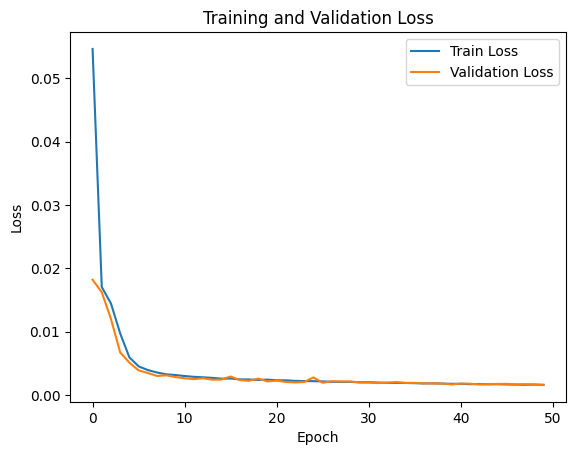

/tmp/ipykernel_381715/3449850615.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))


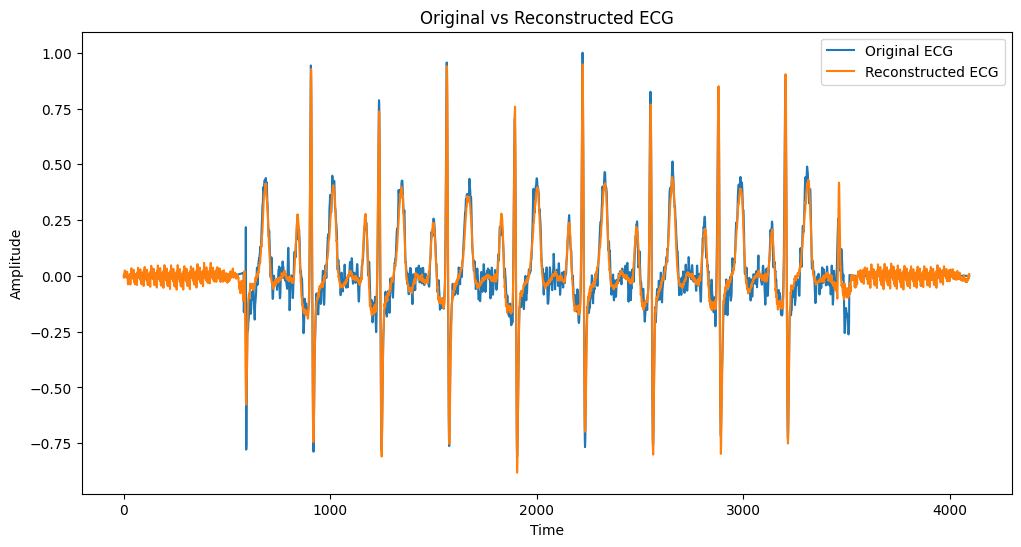

In [13]:
#EXECUTAR MODELO

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Supondo que seu vetor X já esteja carregado como uma matriz numpy com shape (10500, 4096)
# Se ainda não estiver carregado, use np.load() ou outra forma de carregar seus dados
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Normalizar os dados entre 0 e 1 para um melhor desempenho do autoencoder
print("Formato original de X:", X.shape)
epsilon = 1e-8
X = X / (np.max(np.abs(X), axis=1, keepdims=True) + epsilon)

print("Formato antes do reshape:", X.shape)
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Formato após o reshape:", X.shape)

total_elements = np.prod(X.shape)
print("Número total de elementos:", total_elements)
# Dividir os dados em conjuntos de treino e teste
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Convertendo os dados para tensores do PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Criar DataLoaders para treino e teste
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Instanciar o modelo e mover para a GPU se disponível
autoencoder = Autoencoder().to(device)

# Definir o otimizador e a função de perda
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Treinar o modelo
num_epochs = 50
early_stopping_patience = 10
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = data[0]
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            inputs = data[0]
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Plotar a perda de treino e validação
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Carregar o melhor modelo
autoencoder.load_state_dict(torch.load('best_autoencoder.pth'))

# Selecionar um exemplo de ECG para reconstruir
idx = np.random.randint(0, X_test.shape[0])
original_ecg = X_test_tensor[idx].unsqueeze(0)

# Reconstruir o ECG usando o autoencoder
autoencoder.eval()
with torch.no_grad():
    reconstructed_ecg = autoencoder(original_ecg)

# Plotar o ECG original e o reconstruído
plt.figure(figsize=(12, 6))
plt.plot(original_ecg.cpu().numpy().flatten(), label='Original ECG')
plt.plot(reconstructed_ecg.cpu().numpy().flatten(), label='Reconstructed ECG')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed ECG')
plt.show()